This notebook contains a generator class for Keras called `BSONIterator` that can read directly from the BSON data. You can use it in combination with `ImageDataGenerator` for doing data augmentation.

In [1]:
import os, sys, math, io
import numpy as np
import pandas as pd
import multiprocessing as mp
import bson
import struct

%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

from collections import defaultdict
from tqdm import *

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
keras.__version__, tf.__version__

('2.0.8', '1.3.0')

In [3]:
#data_dir = "/home/manojps/Documents/deep_learning/Project"
data_dir = "C:\\Users\\msaha\\Documents\\Deep_Learning\\Project\\"

train_bson_path = os.path.join(data_dir, "train.bson")
num_train_products = 7069896

# train_bson_path = os.path.join(data_dir, "train_example.bson")
# num_train_products = 82

test_bson_path = os.path.join(data_dir, "test.bson")
num_test_products = 1768182

print(test_bson_path)

C:\Users\msaha\Documents\Deep_Learning\Project\test.bson


# Part 1: Create lookup tables

The generator uses several lookup tables that describe the layout of the BSON file, which products and images are part of the training/validation sets, and so on.

You only need to generate these tables once, as they get saved to CSV files. If you already have these CSV files, skip to part 2.

## Lookup table for categories

In [4]:
categories_path = os.path.join(data_dir, "category_names.csv")
#categories_df = pd.read_csv(categories_path, index_col="category_id")
categories_df = pd.read_csv(categories_path)

# Maps the category_id to an integer index. This is what we'll use to
# one-hot encode the labels.
categories_df["category_idx"] = pd.Series(range(len(categories_df)), index=categories_df.index)

#categories_df.to_csv("categories.csv")
categories_df.head()

,category_id,category_level1,category_level2,category_level3,category_idx
0,1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0
1,1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1
2,1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,2
3,1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,3
4,1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,4


In [5]:
# Create a dataframe with category level1 idx
cat1_level_df = pd.DataFrame(categories_df.category_level1.unique())
cat1_level_df.rename(columns={0: "category_level1"}, inplace=True)
cat1_level_df["cat1_idx"] = pd.Series(range(len(cat1_level_df)), index=cat1_level_df.index)
cat1_level_df.head()

,category_level1,cat1_idx
0,ABONNEMENT / SERVICES,0
1,AMENAGEMENT URBAIN - VOIRIE,1
2,ANIMALERIE,2
3,APICULTURE,3
4,ART DE LA TABLE - ARTICLES CULINAIRES,4


In [6]:
cat1_level_df.cat1_idx.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], dtype=int64)

In [7]:
# Merge categories_df and cat1_levle_df into categories_df
categories_df = pd.merge(categories_df, cat1_level_df, on="category_level1", how="inner")
categories_df.head()

,category_id,category_level1,category_level2,category_level3,category_idx,cat1_idx
0,1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0,0
1,1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1,1
2,1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,2,1
3,1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,3,1
4,1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,4,1


In [8]:
categories_df.cat1_idx.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], dtype=int64)

In [9]:
# Create a dataframe with category level2 idx
cat2_level_df = pd.DataFrame(categories_df.category_level2.unique())
cat2_level_df.rename(columns={0:"category_level2"}, inplace=True)
cat2_level_df["cat2_idx"] = pd.Series(range(len(cat2_level_df)), index = cat2_level_df.index)
cat2_level_df.head()

,category_level2,cat2_idx
0,CARTE PREPAYEE,0
1,AMENAGEMENT URBAIN,1
2,SIGNALETIQUE,2
3,SIGNALISATION ROUTIERE,3
4,VOIRIE,4


In [10]:
cat2_level_df.cat2_idx.unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [11]:
# Merge categories_df and cat2_level_df into categories_df
categories_df = pd.merge(categories_df, cat2_level_df, on="category_level2", how="inner")
categories_df.head()

,category_id,category_level1,category_level2,category_level3,category_idx,cat1_idx,cat2_idx
0,1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0,0,0
1,1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1,1,1
2,1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,2,1,1
3,1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,3,1,1
4,1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,4,1,2


In [12]:
categories_df.cat1_idx.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 38,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 21, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 47,
       32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 48], dtype=int64)

In [13]:
categories_df = categories_df.set_index("category_id")
categories_df.head()

,category_level1,category_level2,category_level3,category_idx,cat1_idx,cat2_idx
category_id,,,,,,
1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0,0,0
1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1,1,1
1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,2,1,1
1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,3,1,1
1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,4,1,2


In [14]:
# Write dataframe to CSV file
categories_df.to_csv("categories.csv")

Create dictionaries for quick lookup of `category_id` to `category_idx` mapping.

In [15]:
def make_category_tables():
    cat2idx = {}
    idx2cat = {}
    for ir in categories_df.itertuples():
        category_id = ir[0]
        #category_idx = ir[4] # Category level3
        category_idx = ir[5] # Category level1
        #category_idx = ir[6] # Category level2 
        cat2idx[category_id] = category_idx
        idx2cat[category_idx] = category_id
    return cat2idx, idx2cat

In [16]:
cat2idx, idx2cat = make_category_tables()

In [17]:
# Test if it works:
cat2idx[1000012755], idx2cat[4]

(1, 1000020743)

In [18]:
# Garbage collection
# https://stackoverflow.com/questions/32247643/how-to-delete-multiple-pandas-python-dataframes-from-memory-to-save-ram
list = [cat1_level_df, cat2_level_df]
del cat1_level_df, cat2_level_df
del list

## Read the BSON files

We store the offsets and lengths of all items, allowing us random access to the items later.

Inspired by code from: https://www.kaggle.com/vfdev5/random-item-access

Note: this takes a few minutes to execute, but we only have to do it once (we'll save the table to a CSV file afterwards).

In [19]:
def read_bson(bson_path, num_records, with_categories):
    rows = {}
    with open(bson_path, "rb") as f, tqdm(total=num_records) as pbar:
        offset = 0
        while True:
            item_length_bytes = f.read(4)
            if len(item_length_bytes) == 0:
                break

            length = struct.unpack("<i", item_length_bytes)[0]

            f.seek(offset)
            item_data = f.read(length)
            assert len(item_data) == length

            item = bson.BSON.decode(item_data)
            product_id = item["_id"]
            num_imgs = len(item["imgs"])

            row = [num_imgs, offset, length]
            if with_categories:
                row += [item["category_id"]]
            rows[product_id] = row

            offset += length
            f.seek(offset)
            pbar.update()

    columns = ["num_imgs", "offset", "length"]
    if with_categories:
        columns += ["category_id"]

    df = pd.DataFrame.from_dict(rows, orient="index")
    df.index.name = "product_id"
    df.columns = columns
    df.sort_index(inplace=True)
    return df

In [20]:
%time train_offsets_df = read_bson(train_bson_path, num_records=num_train_products, with_categories=True)

100%|█████████████████████████████| 7069896/7069896 [09:45<00:00, 12065.06it/s]


Wall time: 10min 4s


In [21]:
train_offsets_df.head()

,num_imgs,offset,length,category_id
product_id,,,,
0,1,0,6979,1000010653
1,1,6979,7318,1000010653
2,1,14297,5455,1000004079
3,1,19752,4580,1000004141
4,1,24332,6346,1000015539


In [22]:
train_offsets_df.to_csv("train_offsets.csv")

In [24]:
# How many products?
len(train_offsets_df)

7069896

In [25]:
# How many categories?
len(train_offsets_df["category_id"].unique())

5270

In [26]:
# How many images in total?
train_offsets_df["num_imgs"].sum()

12371293

## Create a random train/validation split

We split on products, not on individual images. Since some of the categories only have a few products, we do the split separately for each category.

This creates two new tables, one for the training images and one for the validation images. There is a row for every single image, so if a product has more than one image it occurs more than once in the table.

In [67]:
def make_val_set(df, split_percentage=0.2, drop_percentage=0.):
    # Find the product_ids for each category.
    category_dict = defaultdict(list)
    for ir in tqdm(df.itertuples()):
        category_dict[ir[4]].append(ir[0])

    train_list = []
    val_list = []
    with tqdm(total=len(df)) as pbar:
        for category_id, product_ids in category_dict.items():
            category_idx = cat2idx[category_id]

            # Randomly remove products to make the dataset smaller.
            keep_size = int(len(product_ids) * (1. - drop_percentage))
            if keep_size < len(product_ids):
                product_ids = np.random.choice(product_ids, keep_size, replace=False)

            # Randomly choose the products that become part of the validation set.
            val_size = int(len(product_ids) * split_percentage)
            if val_size > 0:
                val_ids = np.random.choice(product_ids, val_size, replace=False)
            else:
                val_ids = []

            # Create a new row for each image.
            for product_id in product_ids:
                row = [product_id, category_idx, category_id]
                for img_idx in range(df.loc[product_id, "num_imgs"]):
                    if product_id in val_ids:
                        val_list.append(row + [img_idx])
                    else:
                        train_list.append(row + [img_idx])
                pbar.update()
                
    columns = ["product_id", "category_idx", "category_id", "img_idx"]
    train_df = pd.DataFrame(train_list, columns=columns)
    val_df = pd.DataFrame(val_list, columns=columns)   
    return train_df, val_df

Create a 80/20 split. Also drop 90% of all products to make the dataset more manageable. (Note: if `drop_percentage` > 0, the progress bar doesn't go all the way.)

In [68]:
train_images_df, val_images_df = make_val_set(train_offsets_df, split_percentage=0.2, 
                                              drop_percentage=0.95)

7069896it [00:24, 286271.53it/s]
  5%|█▌                             | 351081/7069896 [00:44<14:16, 7846.71it/s]


In [29]:
train_images_df.head()

,product_id,category_idx,category_id,img_idx
0,23073092,45,1000010653,0
1,12122,45,1000010653,0
2,35789,45,1000010653,0
3,35789,45,1000010653,1
4,35789,45,1000010653,2


In [30]:
len(train_images_df.category_id.unique())

5270

In [31]:
categories_df['category_id'] = categories_df.index

In [32]:
categories_df.head()

,category_level1,category_level2,category_level3,category_idx,cat1_idx,cat2_idx,category_id
category_id,,,,,,,
1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0,0,0,1000021794
1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1,1,1,1000012764
1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,2,1,1,1000012776
1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,3,1,1,1000012768
1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,4,1,2,1000012755


In [33]:
train_images_df = pd.merge(train_images_df, categories_df, on ='category_id', how='inner')
train_images_df.head()

,product_id,category_idx_x,category_id,img_idx,category_level1,category_level2,category_level3,category_idx_y,cat1_idx,cat2_idx
0,23073092,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
1,12122,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
2,35789,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
3,35789,45,1000010653,1,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
4,35789,45,1000010653,2,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455


In [34]:
val_images_df = pd.merge(val_images_df, categories_df, on='category_id', how='inner')
val_images_df.head()

,product_id,category_idx_x,category_id,img_idx,category_level1,category_level2,category_level3,category_idx_y,cat1_idx,cat2_idx
0,7054049,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
1,8087964,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
2,7121074,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
3,23140133,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
4,9497901,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455


In [35]:
train_images_df.cat1_idx.unique()

array([45, 22, 10,  6, 35, 47, 27, 14,  5,  7, 29, 17, 37, 43, 30,  9, 11,
       25, 24, 36, 21, 32,  4, 46, 44, 41,  8, 34,  2, 16, 28, 23, 42, 31,
       13, 26, 48, 33, 15, 19, 38, 18,  1, 12, 20, 39,  3,  0, 40], dtype=int64)

In [36]:
#train_new['product_id'].count
len(train_images_df),len(val_images_df)

(1979978, 489930)

In [37]:
train_images_df['category_level1'].value_counts()

TELEPHONIE - GPS                              196514
AUTO - MOTO                                   191050
INFORMATIQUE                                  180089
DECO - LINGE - LUMINAIRE                      178131
LIBRAIRIE                                     138139
BIJOUX -  LUNETTES - MONTRES                  109947
BRICOLAGE - OUTILLAGE - QUINCAILLERIE          99292
JEUX - JOUETS                                  88038
BAGAGERIE                                      69808
SPORT                                          69562
ELECTROMENAGER                                 60393
HYGIENE - BEAUTE - PARFUM                      60250
MUSIQUE                                        59725
CHAUSSURES - ACCESSOIRES                       59186
MEUBLE                                         50712
TV - VIDEO - SON                               48769
ART DE LA TABLE - ARTICLES CULINAIRES          46039
PHOTO - OPTIQUE                                43613
JARDIN - PISCINE                              

In [38]:
val_images_df['category_level1'].value_counts()

TELEPHONIE - GPS                              49155
AUTO - MOTO                                   47441
INFORMATIQUE                                  44863
DECO - LINGE - LUMINAIRE                      44348
LIBRAIRIE                                     34323
BIJOUX -  LUNETTES - MONTRES                  27695
BRICOLAGE - OUTILLAGE - QUINCAILLERIE         24349
JEUX - JOUETS                                 21737
BAGAGERIE                                     17380
SPORT                                         16601
MUSIQUE                                       14916
HYGIENE - BEAUTE - PARFUM                     14910
ELECTROMENAGER                                14808
CHAUSSURES - ACCESSOIRES                      14706
MEUBLE                                        12481
TV - VIDEO - SON                              12189
ART DE LA TABLE - ARTICLES CULINAIRES         11280
PHOTO - OPTIQUE                               10901
JARDIN - PISCINE                               7509
LOISIRS CREA

In [39]:
# len(train_category1["category_idx"].unique()), len(val_images_df["category_idx"].unique())

Quickly verify that the split really is approximately 80-20:

In [40]:
# cat_idx = 5196
# num_train = np.sum(train_category1['category_idx'] == cat_idx)
# num_val = np.sum(val_category1['category_idx'] == cat_idx)
# num_val/num_train

Close enough. ;-) Remember that we split on products but not all products have the same number of images, which is where the slightly discrepancy comes from. (Also, there tend to be fewer validation images if `drop_percentage` > 0.)

Save the lookup tables as CSV so that we don't need to repeat the above procedure again.

In [41]:
#train_images_df.to_csv("train_images.csv")
#val_images_df.to_csv("val_images.csv")

In [ ]:
train_images_df.to_csv("train_category_level1.csv")
val_images_df.to_csv("val_category_level1.csv")
#train_category2.to_csv("train_category2.csv")
#val_category2.to_csv("val_category2.csv")

# Part 2: The generator

First load the lookup tables from the CSV files (you don't need to do this if you just did all the steps from part 1).

In [42]:
def make_category_tables():
    cat2idx = {}
    idx2cat = {}
    for ir in categories_df.itertuples():
        category_id = ir[0]
        #category_idx = ir[4] # Category level3
        category_idx = ir[5] # Category level1
        #category_idx = ir[6] # Category level2 
        cat2idx[category_id] = category_idx
        idx2cat[category_idx] = category_id
    return cat2idx, idx2cat

In [43]:
# categories_df = pd.read_csv("categories.csv", index_col=0)
cat2idx, idx2cat = make_category_tables()

# train_offsets_df = pd.read_csv("train_offsets.csv", index_col=0)
#train_images_df = pd.read_csv("train_images.csv", index_col=0)
# train_images_df = pd.read_csv("train_category_level1.csv", index_col=0)
#val_images_df = pd.read_csv("val_images.csv", index_col=0)
# val_images_df = pd.read_csv("val_category_level1.csv", index_col=0)

In [44]:
train_offsets_df.head()

,num_imgs,offset,length,category_id
product_id,,,,
0,1,0,6979,1000010653
1,1,6979,7318,1000010653
2,1,14297,5455,1000004079
3,1,19752,4580,1000004141
4,1,24332,6346,1000015539


In [45]:
val_images_df.head()

,product_id,category_idx_x,category_id,img_idx,category_level1,category_level2,category_level3,category_idx_y,cat1_idx,cat2_idx
0,7054049,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
1,8087964,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
2,7121074,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
3,23140133,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455
4,9497901,45,1000010653,0,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE,5055,45,455


In [46]:
len(train_images_df)

1979978

In [47]:
train_images_df['cat1_idx'].value_counts()

45    196514
6     191050
22    180089
14    178131
27    138139
9     109947
10     99292
25     88038
7      69808
43     69562
17     60393
21     60250
35     59725
11     59186
34     50712
47     48769
4      46039
37     43613
24     30779
29     26985
41     20848
2      20348
28     15476
26     14902
16     13924
5      10510
32      9381
44      8609
23      6372
36      6274
15      6246
19      6095
33      5887
18      5383
42      5277
48      3682
46      3622
31      2760
8       2643
13      1563
38      1470
30       835
1        458
12       313
20        34
39        25
40         8
0          7
3          5
Name: cat1_idx, dtype: int64

The Keras generator is implemented by the `BSONIterator` class. It creates batches of images (and their one-hot encoded labels) directly from the BSON file. It can be used with multiple workers.

**Note:** For fastest results, put the train.bson and test.bson files on a fast drive (SSD).

See also the code in: https://github.com/fchollet/keras/blob/master/keras/preprocessing/image.py

In [48]:
from keras.preprocessing.image import Iterator
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

class BSONIterator(Iterator):
    def __init__(self, bson_file, images_df, offsets_df, num_class,
                 image_data_generator, lock, target_size=(180, 180), 
                 with_labels=True, batch_size=32, shuffle=False, seed=None):

        self.file = bson_file
        self.images_df = images_df
        self.offsets_df = offsets_df
        self.with_labels = with_labels
        self.samples = len(images_df)
        self.num_class = num_class
        self.image_data_generator = image_data_generator
        self.target_size = tuple(target_size)
        self.image_shape = self.target_size + (3,)

        print("Found %d images belonging to %d classes." % (self.samples, self.num_class))

        super(BSONIterator, self).__init__(self.samples, batch_size, shuffle, seed)
        self.lock = lock

    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros((len(index_array),) + self.image_shape, dtype=K.floatx())
        if self.with_labels:
            batch_y = np.zeros((len(batch_x), self.num_class), dtype=K.floatx())

        for i, j in enumerate(index_array):
            # Protect file and dataframe access with a lock.
            with self.lock:
                image_row = self.images_df.iloc[j]
                product_id = image_row["product_id"]
                offset_row = self.offsets_df.loc[product_id]

                # Read this product's data from the BSON file.
                self.file.seek(offset_row["offset"])
                item_data = self.file.read(offset_row["length"])

            # Grab the image from the product.
            item = bson.BSON.decode(item_data)
            img_idx = image_row["img_idx"]
            bson_img = item["imgs"][img_idx]["picture"]

            # Load the image.
            img = load_img(io.BytesIO(bson_img), target_size=self.target_size)

            # Preprocess the image.
            x = img_to_array(img)
            x = self.image_data_generator.random_transform(x)
            x = self.image_data_generator.standardize(x)

            # Add the image and the label to the batch (one-hot encoded).
            batch_x[i] = x
            if self.with_labels:
                #batch_y[i, image_row["category_idx"]] = 1
                batch_y[i, image_row["cat1_idx"]] = 1

        if self.with_labels:
            return batch_x, batch_y
        else:
            return batch_x

    def next(self):
        with self.lock:
            index_array = next(self.index_generator)
#         return self._get_batches_of_transformed_samples(index_array)
        return self._get_batches_of_transformed_samples(index_array[0])
    

In [49]:
train_bson_file = open(train_bson_path, "rb")

Because the training and validation generators read from the same BSON file, they need to use the same lock to protect it.

In [52]:
import threading
lock = threading.Lock()

In [50]:
len(train_images_df['cat1_idx'].unique())

49

Create a generator for training and a generator for validation.

In [53]:
num_classes = 5270
#num_classes = len(train_images_df['category_idx'].unique())
num_train_images = len(train_images_df)
num_val_images = len(val_images_df)
batch_size = 400

# Tip: use ImageDataGenerator for data augmentation and preprocessing.
train_datagen = ImageDataGenerator()
train_gen = BSONIterator(train_bson_file, train_images_df, train_offsets_df, 
                         num_classes, train_datagen, lock,
                         batch_size=batch_size, shuffle=True)

val_datagen = ImageDataGenerator()
val_gen = BSONIterator(train_bson_file, val_images_df, train_offsets_df,
                       num_classes, val_datagen, lock,
                       batch_size=batch_size, shuffle=True)

Found 1979978 images belonging to 5270 classes.
Found 489930 images belonging to 5270 classes.


How fast is the generator? Create a single batch:

In [54]:
next(train_gen)  # warm-up

%time bx, by = next(train_gen)

Wall time: 3.54 s


Does it really output images and one-hot encoded class labels? Note that the images are pre-processed (and augmented) and therefore may look weird.

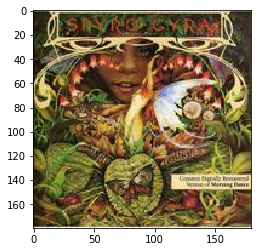

In [55]:
plt.imshow(bx[-1].astype(np.uint8))

In [56]:
cat_idx = np.argmax(by[-1])
cat_id = idx2cat[cat_idx]
categories_df.loc[cat_id]

category_level1                          MUSIQUE
category_level2                           VINYLE
category_level3    VINYLE VARIETE INTERNATIONALE
category_idx                                3977
cat1_idx                                      35
cat2_idx                                     350
category_id                           1000018340
Name: 1000018340, dtype: object

In [57]:
%time bx, by = next(val_gen)

Wall time: 3.91 s


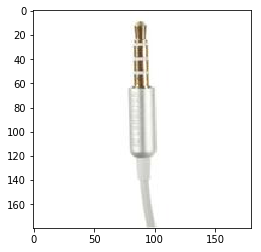

In [58]:
plt.imshow(bx[-1].astype(np.uint8))

In [59]:
cat_idx = np.argmax(by[-1])
cat_id = idx2cat[cat_idx]
categories_df.loc[cat_id]

category_level1                    TELEPHONIE - GPS
category_level2                     TELEPHONIE FIXE
category_level3    TELEPHONE FIXE - PACK TELEPHONES
category_idx                                   5108
cat1_idx                                         45
cat2_idx                                        460
category_id                              1000010619
Name: 1000010619, dtype: object

# Part 3: Training

Create a very simple Keras model and train it, to test that the generators work.

In [60]:
#from keras.models import Sequential
#from keras.layers import Dropout, Flatten, Dense
#from keras.layers.convolutional import Conv2D
#from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D

#model = Sequential()
#model.add(Conv2D(32, 3, padding="same", activation="relu", input_shape=(180, 180, 3)))
#model.add(MaxPooling2D())
#model.add(Conv2D(64, 3, padding="same", activation="relu"))
#model.add(MaxPooling2D())
#model.add(Conv2D(128, 3, padding="same", activation="relu"))
#model.add(MaxPooling2D())
#model.add(GlobalAveragePooling2D())
#model.add(Dense(num_classes, activation="softmax"))

#model.compile(optimizer="adam",
#              loss="categorical_crossentropy",
#              metrics=["accuracy"])

#model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 22, 22, 128)       0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 128)               0         
__________

In [65]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 5270 classes
predictions = Dense(5270, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_271 (Conv2D)              (None, None, None, 32 864         input_4[0][0]                    
____________________________________________________________________________________________________
batch_normalization_267 (BatchNo (None, None, None, 32 96          conv2d_271[0][0]                 
____________________________________________________________________________________________________
activation_267 (Activation)      (None, None, None, 32 0           batch_normalization_267[0][0]    
___________________________________________________________________________________________

____________________________________________________________________________________________________
conv2d_296 (Conv2D)              (None, None, None, 64 18432       average_pooling2d_28[0][0]       
____________________________________________________________________________________________________
batch_normalization_286 (BatchNo (None, None, None, 64 192         conv2d_290[0][0]                 
____________________________________________________________________________________________________
batch_normalization_288 (BatchNo (None, None, None, 64 192         conv2d_292[0][0]                 
____________________________________________________________________________________________________
batch_normalization_291 (BatchNo (None, None, None, 96 288         conv2d_295[0][0]                 
____________________________________________________________________________________________________
batch_normalization_292 (BatchNo (None, None, None, 64 192         conv2d_296[0][0]        

____________________________________________________________________________________________________
conv2d_319 (Conv2D)              (None, None, None, 19 215040      activation_314[0][0]             
____________________________________________________________________________________________________
conv2d_320 (Conv2D)              (None, None, None, 19 147456      average_pooling2d_30[0][0]       
____________________________________________________________________________________________________
batch_normalization_307 (BatchNo (None, None, None, 19 576         conv2d_311[0][0]                 
____________________________________________________________________________________________________
batch_normalization_310 (BatchNo (None, None, None, 19 576         conv2d_314[0][0]                 
____________________________________________________________________________________________________
batch_normalization_315 (BatchNo (None, None, None, 19 576         conv2d_319[0][0]        

batch_normalization_339 (BatchNo (None, None, None, 19 576         conv2d_343[0][0]                 
____________________________________________________________________________________________________
activation_339 (Activation)      (None, None, None, 19 0           batch_normalization_339[0][0]    
____________________________________________________________________________________________________
conv2d_344 (Conv2D)              (None, None, None, 19 258048      activation_339[0][0]             
____________________________________________________________________________________________________
batch_normalization_340 (BatchNo (None, None, None, 19 576         conv2d_344[0][0]                 
____________________________________________________________________________________________________
activation_340 (Activation)      (None, None, None, 19 0           batch_normalization_340[0][0]    
___________________________________________________________________________________________

                                                                   activation_355[0][0]             
____________________________________________________________________________________________________
concatenate_6 (Concatenate)      (None, None, None, 76 0           activation_358[0][0]             
                                                                   activation_359[0][0]             
____________________________________________________________________________________________________
activation_360 (Activation)      (None, None, None, 19 0           batch_normalization_360[0][0]    
____________________________________________________________________________________________________
mixed10 (Concatenate)            (None, None, None, 20 0           activation_352[0][0]             
                                                                   mixed9_1[0][0]                   
                                                                   concatenate_6[0][0]     

In [66]:
batch_size = 400
# To train the model:
model.fit_generator(train_gen,
                    steps_per_epoch = num_train_images // batch_size,
                    epochs = 1,
                    class_weight = 'auto',
                    validation_data = val_gen,
                    validation_steps = num_val_images // batch_size,
#                     workers = 8,
                   verbose =1)

Epoch 1/1
  11/4949 [..............................] - ETA: 35940s - loss: 8.6206 - acc: 0.0000e+00 - top_k_categorical_accuracy: 0.0000e+ - ETA: 22854s - loss: 6.9399 - acc: 0.0287 - top_k_categorical_accuracy: 0.0937       - ETA: 22607s - loss: 6.0227 - acc: 0.0375 - top_k_categorical_accuracy: 0.15 - ETA: 21861s - loss: 5.4705 - acc: 0.0581 - top_k_categorical_accuracy: 0.21 - ETA: 21478s - loss: 5.1459 - acc: 0.0620 - top_k_categorical_accuracy: 0.25 - ETA: 21048s - loss: 4.8970 - acc: 0.0729 - top_k_categorical_accuracy: 0.28 - ETA: 20919s - loss: 4.7009 - acc: 0.0843 - top_k_categorical_accuracy: 0.31 - ETA: 20984s - loss: 4.5496 - acc: 0.0928 - top_k_categorical_accuracy: 0.33 - ETA: 20993s - loss: 4.4241 - acc: 0.0953 - top_k_categorical_accuracy: 0.35 - ETA: 20927s - loss: 4.3166 - acc: 0.1032 - top_k_categorical_accuracy: 0.36 - ETA: 20910s - loss: 4.2257 - acc: 0.1159 - top_k_categorical_accuracy: 0.3775

KeyboardInterrupt: 

In [ ]:
model.save('model_inception_0.2.h5')

In [ ]:
# To evaluate on the validation set:
y = model.evaluate_generator(val_gen, steps=num_val_images // batch_size, workers=8)

In [ ]:
y

In [ ]:
num_val_images, batch_size

In [ ]:
y_pred = model.predict_generator(val_gen, steps=num_val_images//batch_size)

In [ ]:
np.set_printoptions(threshold=np.nan)

In [ ]:
np.max(y_pred, axis=1)

In [ ]:
np.max(y_pred)

In [ ]:
y_pred[300][5236], np.argmax(y_pred[300])

In [ ]:
np.argmax(y_pred, axis=1)

In [ ]:
len(y_pred), len(val_images_df), len(y)

In [ ]:
y_pred.shape, val_images_df.shape

In [ ]:
val_temp2 = val_images_df[0:len(y_pred)]
len(val_temp2)

In [ ]:
y_pred = model.predict_generator(val_gen, workers=8)

In [ ]:
y_pred1 = model.predict(val_images_df)

# Part 4: Test set predictions

Note: The previous version of this kernel used `BSONIterator` to load the test set images in batches. However, storing the prediction results takes up a huge amount of memory. 

I suggest using a different kind of generator instead, something like the following:

```
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

submission_df = pd.read_csv(data_dir + "sample_submission.csv")
submission_df.head()

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
data = bson.decode_file_iter(open(test_bson_path, "rb"))

with tqdm(total=num_test_products) as pbar:
    for c, d in enumerate(data):
        product_id = d["_id"]
        num_imgs = len(d["imgs"])

        batch_x = np.zeros((num_imgs, 180, 180, 3), dtype=K.floatx())

        for i in range(num_imgs):
            bson_img = d["imgs"][i]["picture"]

            # Load and preprocess the image.
            img = load_img(io.BytesIO(bson_img), target_size=(180, 180))
            x = img_to_array(img)
            x = test_datagen.random_transform(x)
            x = test_datagen.standardize(x)

            # Add the image to the batch.
            batch_x[i] = x

        prediction = model.predict(batch_x, batch_size=num_imgs)
        avg_pred = prediction.mean(axis=0)
        cat_idx = np.argmax(avg_pred)
        
        submission_df.iloc[c]["category_id"] = idx2cat[cat_idx]        
        pbar.update()
        
submission_df.to_csv("my_submission.csv.gz", compression="gzip", index=False)        
```

In [ ]:
num_classes = 5270
#num_classes = len(train_images_df['category_idx'].unique())
num_test_images = len(test_images_df)
batch_size = 1000

# Tip: use ImageDataGenerator for data augmentation and preprocessing.
test_datagen = ImageDataGenerator()
test_gen = BSONIterator(test_bson_file, test_images_df, train_offsets_df, 
                         num_classes, train_datagen, lock,
                         batch_size=batch_size, shuffle=True)